In [408]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data Cleaning

In [409]:
# load data
trn_data = pd.read_csv("./data/train_data.csv")
test_data  = pd.read_csv("./data/test_data.csv")
#test_data = pd.read_csv("new_race_data.csv")


In [410]:
# change event type to int. 1 for race, 0 for sprint.
trn_data["Event_Type"] = (trn_data["Event_Type"] == "Race").astype(int)
test_data["Event_Type"] = (test_data["Event_Type"] == "Race").astype(int)

In [411]:
# clean NaNs
cols_to_fill = ["Sprint_Qual_Position", "Sprint_Race_Position","Sector1Time", "Sector2Time", "Sector3Time", "SpeedST", "Stint", "Race_Position"]
trn_data[cols_to_fill] = trn_data[cols_to_fill].fillna(-1)

test_data[cols_to_fill] = test_data[cols_to_fill].fillna(-1)

# have to think if this is the right way to do this



In [412]:
def check_teams():
    unique_teams_pre_2025 = trn_data["TeamName"].unique()
    unique_teams_pre_2025.sort()
    unique_teams_2025 = test_data["TeamName"].unique()
    unique_teams_2025.sort()
    print(unique_teams_pre_2025)
    print(unique_teams_2025)

    teams_2025 = set(unique_teams_2025)
    unknown_teams = []
    for team in unique_teams_pre_2025: 
        if team not in teams_2025:
            unknown_teams.append(team)
    print(f"Unknown Teams: {unknown_teams}")

check_teams()

['Alfa Romeo' 'AlphaTauri' 'Alpine' 'Aston Martin' 'Ferrari'
 'Haas F1 Team' 'Kick Sauber' 'McLaren' 'Mercedes' 'RB' 'Red Bull Racing'
 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: ['Alfa Romeo', 'AlphaTauri', 'RB']


In [413]:
# edit pre 2025 teams to match 2025 teams. 
# alphatauri == RB == Racing Bulls
# alfa romeo == kick sauber

trn_data.loc[(trn_data["TeamName"] == "AlphaTauri") | (trn_data["TeamName"] == "RB"), "TeamName"] = "Racing Bulls"
trn_data.loc[(trn_data["TeamName"] == "Alfa Romeo"), "TeamName"] = "Kick Sauber"
check_teams()


['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
['Alpine' 'Aston Martin' 'Ferrari' 'Haas F1 Team' 'Kick Sauber' 'McLaren'
 'Mercedes' 'Racing Bulls' 'Red Bull Racing' 'Williams']
Unknown Teams: []


In [414]:
unique_teams = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_teams = unique_teams["TeamName"].unique()
len(unique_teams)

10

In [415]:
unique_teams

array(['Red Bull Racing', 'Racing Bulls', 'Alpine', 'Ferrari',
       'Aston Martin', 'Haas F1 Team', 'Williams', 'Kick Sauber',
       'McLaren', 'Mercedes'], dtype=object)

In [416]:
def get_all_drivers():
    all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
    all_drivers = all_drivers.groupby("DriverNumber")["BroadcastName"].unique().apply(list).to_dict()
    return all_drivers

# issues found here: 1) driver number not unqiue (e.g. two diff drivers can share the same driver number in history) 2) one driver can have multiple driver numbers through history.
# Soln: need to create a bijection. By taking all the unique driver names and creating your own mapping or just one hot encoding? 

In [417]:
# code to get rid of nan values for driver broadcast name
all_drivers = get_all_drivers()
trn_data.iloc[35,1] = all_drivers[trn_data.iloc[35,0]][0]
trn_data.iloc[725,1] = all_drivers[trn_data.iloc[725,0]][0]

# fix 'A ANTONELLI', 'K ANTONELLI'
test_data.iloc[2,1] = 'K ANTONELLI'

In [418]:
trn_data[trn_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [419]:
test_data[test_data.isna().any(axis=1)]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position


In [420]:
test_data.loc[test_data["DriverNumber"]==12,:]

,DriverNumber,BroadcastName,TeamName,Round_Number,Country,Location,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,Sector2Time,Sector3Time,SpeedST,Stint,Race_Position
2,12,K ANTONELLI,Mercedes,1,Australia,Melbourne,2025,1,-1.0,-1.0,16.0,36.392589,23.503333,47.519421,255.947368,6.0,4.0
22,12,K ANTONELLI,Mercedes,2,China,Shanghai,2025,0,7.0,7.0,8.0,26.524509,29.694607,42.096607,319.732143,2.0,6.0
42,12,K ANTONELLI,Mercedes,3,Japan,Suzuka,2025,1,-1.0,-1.0,6.0,32.952885,42.184377,18.081623,298.924528,2.0,6.0
62,12,K ANTONELLI,Mercedes,4,Bahrain,Sakhir,2025,1,-1.0,-1.0,4.0,32.644768,43.987333,24.861965,308.678571,4.0,11.0
82,12,K ANTONELLI,Mercedes,5,Saudi Arabia,Jeddah,2025,1,-1.0,-1.0,5.0,36.267633,30.152100,31.564760,304.000000,2.0,6.0


In [421]:
# issue 1 with driver numbers

drivers = get_all_drivers()
for key in drivers:
    if len(drivers[key]) > 1: print(f"{key}:{drivers[key]}")


5:['S VETTEL', 'G BORTOLETO']
6:['N LATIFI', 'I HADJAR']


In [422]:
# issue 2 with driver numbers 

arr_from_drivers = []
for key in drivers: 
    for driver in drivers[key]: 
        arr_from_drivers.append(driver)

arr_from_drivers.sort()

from collections import Counter
counts = Counter(arr_from_drivers)

# Filter duplicates
duplicates = {item: count for item, count in counts.items() if count > 1}

print(duplicates)

{'J DOOHAN': 2, 'L LAWSON': 2, 'N DE VRIES': 2, 'O BEARMAN': 3}


In [423]:
all_drivers = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_driver_names = all_drivers["BroadcastName"].unique()
unique_driver_names.sort()
len(unique_driver_names)


31

In [424]:
unique_driver_names

array(['A ALBON', 'C LECLERC', 'C SAINZ', 'D RICCIARDO', 'E OCON',
       'F ALONSO', 'F COLAPINTO', 'G BORTOLETO', 'G RUSSELL', 'G ZHOU',
       'I HADJAR', 'J DOOHAN', 'K ANTONELLI', 'K MAGNUSSEN', 'L HAMILTON',
       'L LAWSON', 'L NORRIS', 'L SARGEANT', 'L STROLL', 'M SCHUMACHER',
       'M VERSTAPPEN', 'N DE VRIES', 'N HULKENBERG', 'N LATIFI',
       'O BEARMAN', 'O PIASTRI', 'P GASLY', 'S PEREZ', 'S VETTEL',
       'V BOTTAS', 'Y TSUNODA'], dtype=object)

In [425]:
unique_locations = pd.concat([trn_data,test_data],axis=0,ignore_index=True)
unique_locations = unique_locations["Location"].unique()
len(unique_locations)

25

In [426]:
unique_locations

array(['Sakhir', 'Jeddah', 'Melbourne', 'Imola', 'Miami', 'Barcelona',
       'Monaco', 'Baku', 'Montréal', 'Silverstone', 'Spielberg',
       'Le Castellet', 'Budapest', 'Spa-Francorchamps', 'Zandvoort',
       'Monza', 'Marina Bay', 'Suzuka', 'Austin', 'Mexico City',
       'São Paulo', 'Yas Island', 'Lusail', 'Las Vegas', 'Shanghai'],
      dtype=object)

In [427]:
# one hot encode: driver, team, circuit, year

# have to concatenate data so that one hot encoding is aligned across train and test dataset 
data = pd.concat([trn_data,test_data], axis=0, ignore_index=True)

#Just testing to see if this works better.
#data = pd.get_dummies(data,columns=['TeamName'], drop_first=True)
""" After doing some model eval, these team features separated the data better than others which makes sense b/c top teams will have class==1 more often """
data['TopTeam_Red Bull Racing'] = (data['TeamName'] == 'Red Bull Racing').astype(int)
data['TopTeam_Ferrari'] = (data['TeamName'] == 'Ferrari').astype(int)
data['TopTeam_Mercedes'] = (data['TeamName'] == 'Mercedes').astype(int)
data['TopTeam_McLaren'] = (data['TeamName'] == 'McLaren').astype(int)
data.drop(columns=["TeamName"], inplace=True)

#data = pd.get_dummies(data,columns=['Location'], drop_first=True) # maybe don't one hot encode location. might just add noise. test with it first then see how dropping it changes. 
data = data.drop(columns=["Location"])

# Data Exploration

In [428]:
#data.corr()

In [429]:
def plt_race_positions(driverNumbers):
    df = pd.DataFrame()
    plt.figure(figsize=(20,10))
    for driver in driverNumbers:
        y = data.loc[data["DriverNumber"]==driver,["Race_Position"]]
        name = data.loc[data["DriverNumber"]==driver,["BroadcastName"]].iloc[0,0]
        x = [i for i in range(1,len(y)+1,1)]
        plt.plot(x,y,label=name)
 
    plt.legend()
    plt.show()

        

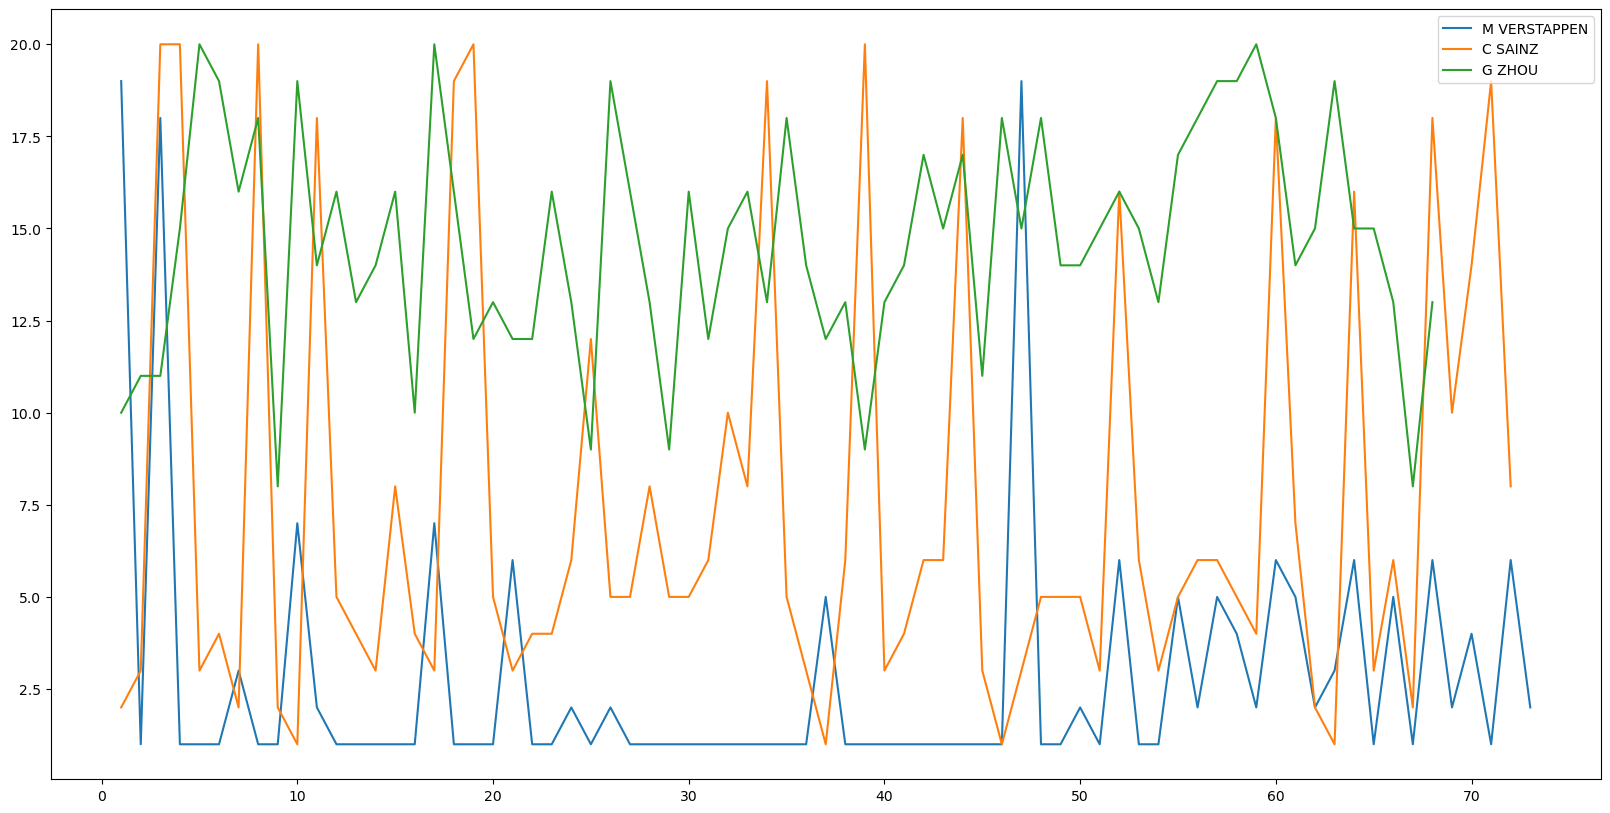

In [430]:
plt_race_positions([1,55,24])

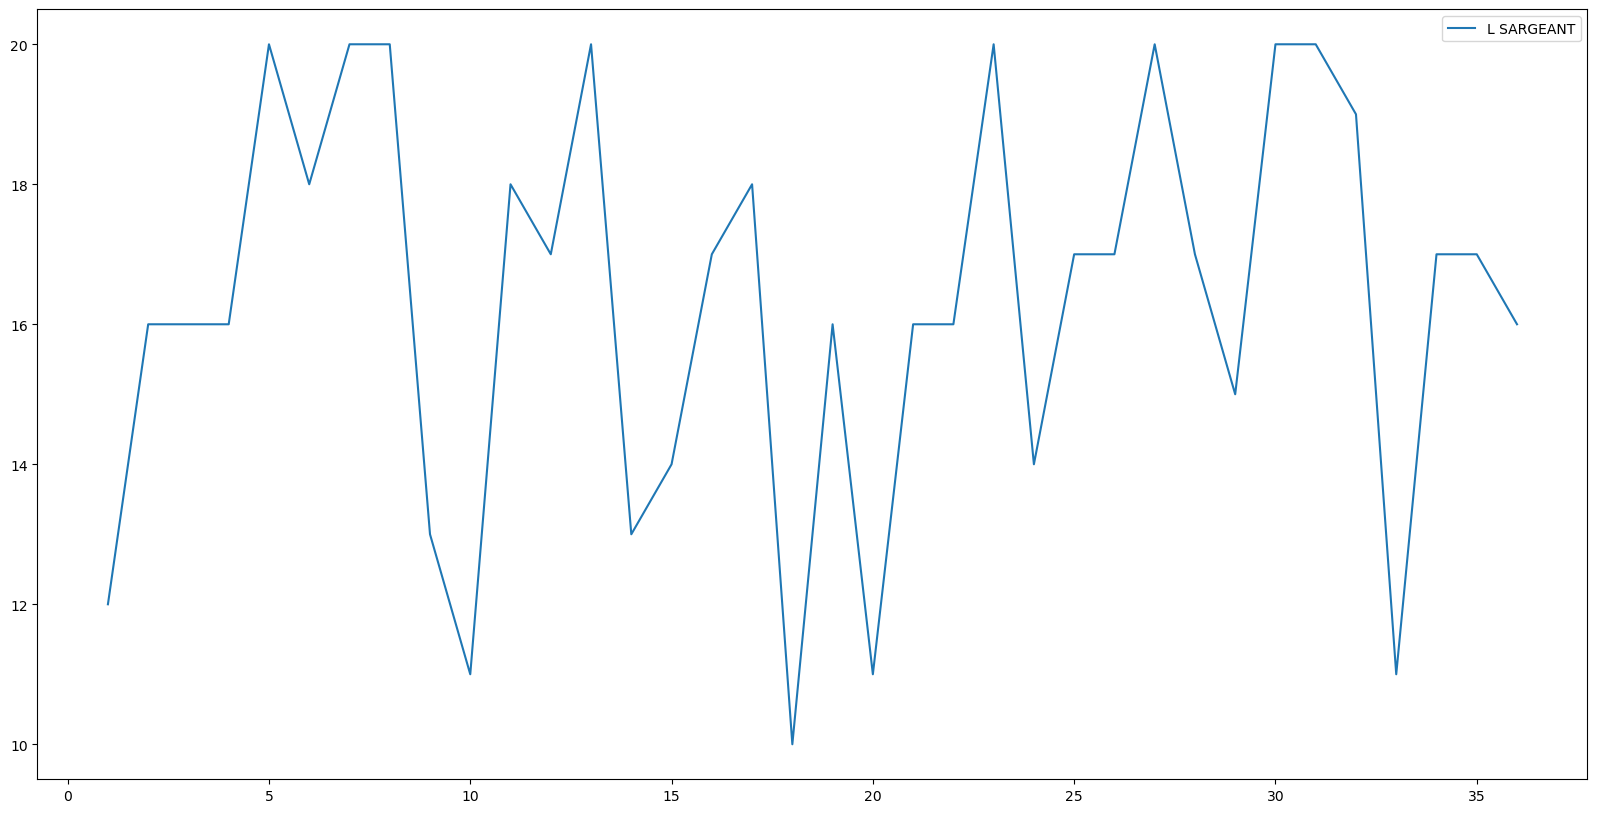

In [431]:
plt_race_positions([2])

In [432]:
# check balance of target
data["Race_Position"].value_counts()

Race_Position
 19.0    73
 14.0    73
 6.0     73
 4.0     73
 16.0    73
 2.0     73
 11.0    73
 3.0     73
 15.0    73
 7.0     73
 17.0    73
 10.0    73
 13.0    73
 8.0     73
 5.0     73
 12.0    73
 1.0     73
 9.0     73
 18.0    73
 20.0    70
-1.0      2
Name: count, dtype: int64

In [433]:
data = data.sort_values(['Year','Round_Number','BroadcastName'])

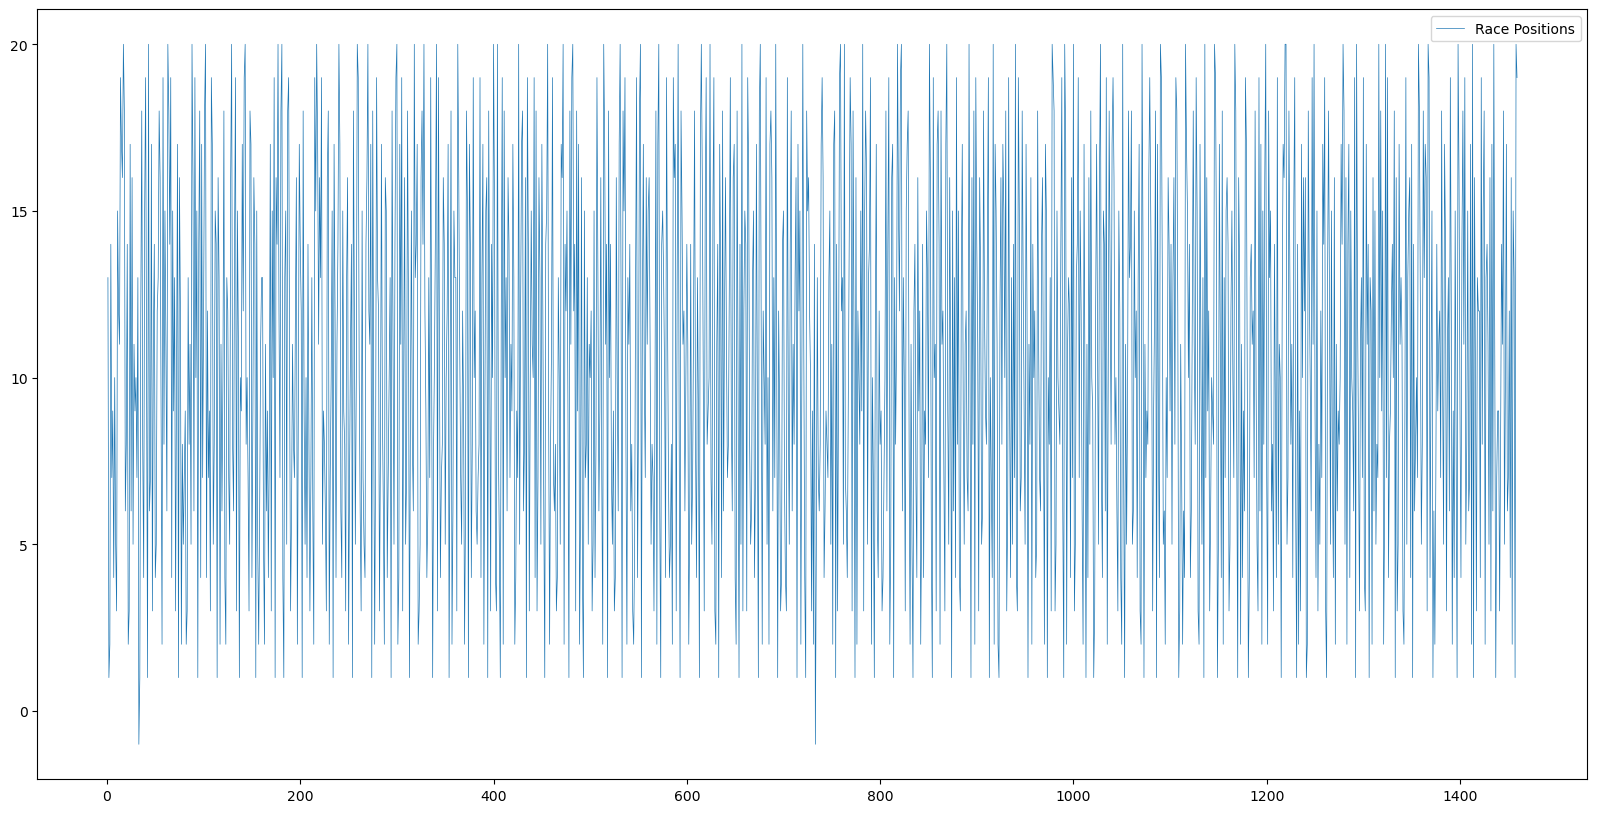

In [434]:
# plot all race positions

plt.figure(figsize=(20,10))
y = data["Race_Position"]
x = [i for i in range(1,len(y)+1,1)]
plt.plot(x,y,linewidth=0.5,label="Race Positions")
plt.legend()
plt.show()

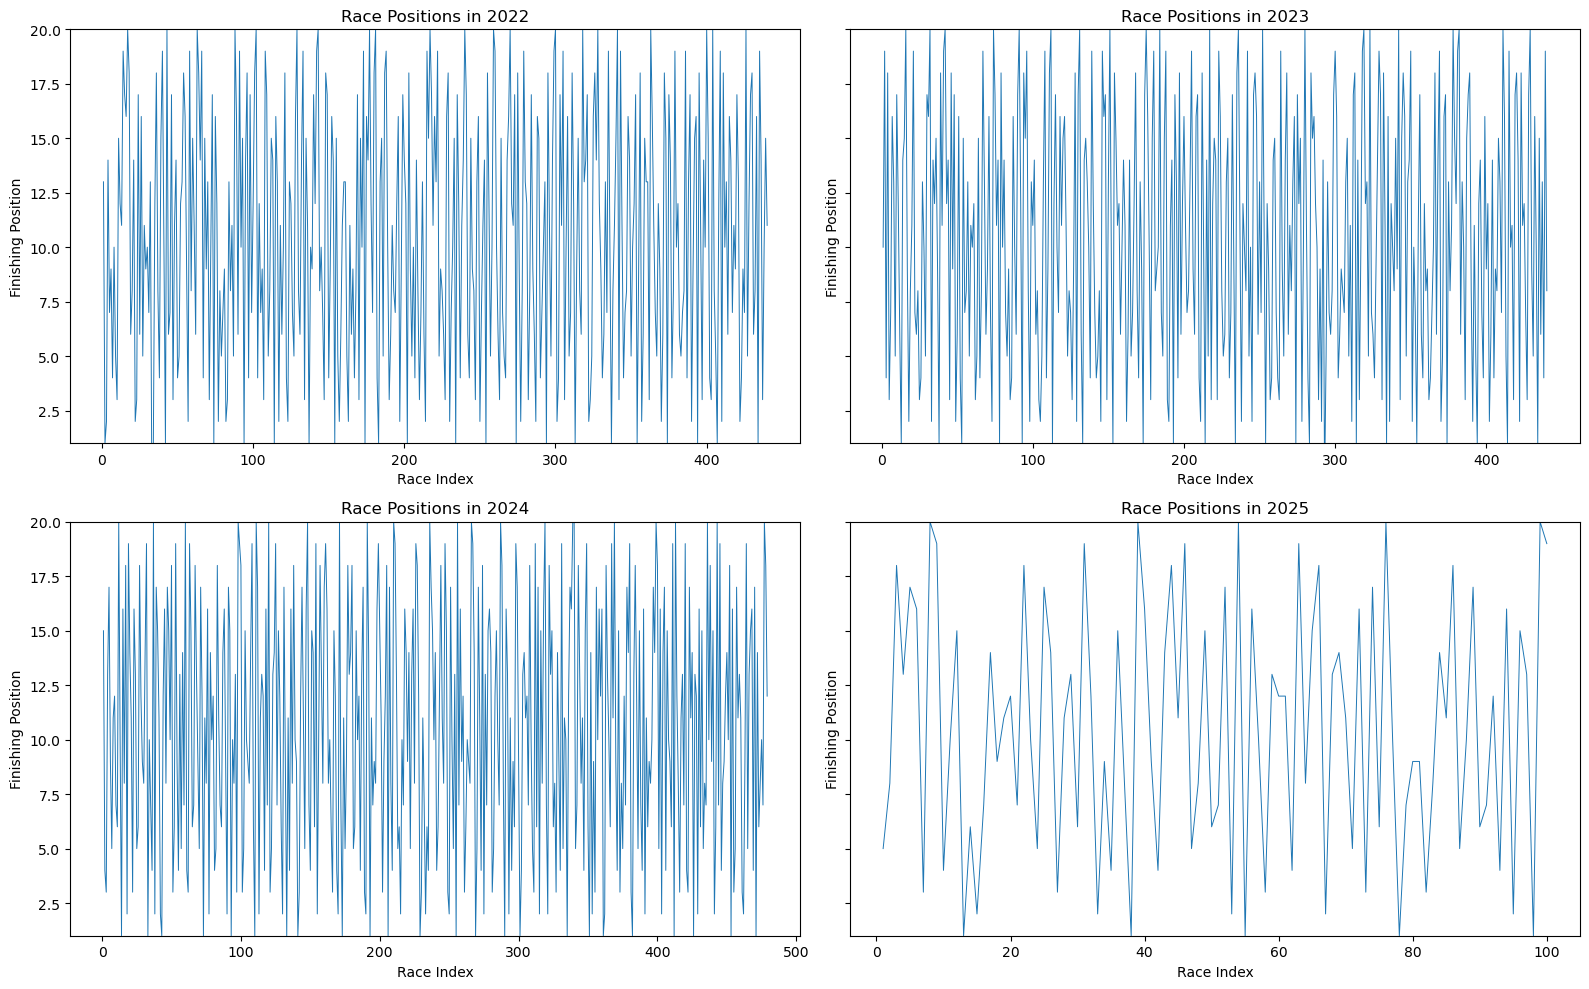

In [435]:
# plot race positions by year

years = [2022, 2023, 2024, 2025]
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axes = axes.flatten()
for ax, year in zip(axes, years):
    df_year = data[data["Year"] == year]
    y = df_year["Race_Position"].values
    x = range(1, len(y) + 1)
    
    ax.plot(x, y, linewidth=0.7)
    ax.set_title(f"Race Positions in {year}")
    ax.set_xlabel("Race Index")
    ax.set_ylabel("Finishing Position")
    ax.set_ylim(1, 20)          

plt.tight_layout()
plt.show()

In [436]:
# plot race position by location

def plt_race_pos_by_location(locations):
    plt.figure(figsize=(20,10))
    #colors = ["red","blue","green"]
    for location in locations:
        y = data.loc[data[location]==1,["Race_Position"]]
        x = [i for i in range(1,len(y)+1,1)]
        plt.plot(x,y,linewidth=0.5,label=f"{location}")
    plt.legend()
    plt.show()

#plt_race_pos_by_location(['Location_Silverstone','Location_Monza','Location_Sakhir'])
#plt_race_pos_by_location(['Location_Silverstone','Location_Monza'])

# Feature Engineering

come up with equaton for pos gained. shouldbn't penalize thos in top 5 that gain very few because they stayed in the top 5. need to balance that.

In [437]:
# Create Race_Date_Code feature, to sort chornologically for lagging calculations
data['Race_Date_Code'] = data['Year']*100 + data['Round_Number']

In [438]:
# Calculate Driver Encoding Feature 

data = data.sort_values(['BroadcastName','Race_Date_Code']) 
data['n_past']  = data.groupby('BroadcastName').cumcount() # number of past races up to t-1
#data['sum_past'] = data.groupby('BroadcastName')['Race_Position'].cumsum() - data['Race_Position']
#data['avg_past'] = data['sum_past'] / data['n_past']

mu = data['Race_Position'].mean() # global mean 
k  = 20 # smoothing parameter (defines the number of races needed to be considered not a rookie)
alpha = 0.3 # EMA smoothing factor. means alpha% weight on the most recent race i.e. St = alpha * xt + (1-alpha) * St-1

data['ema_past'] = (
    data
    .groupby('BroadcastName',group_keys=False)['Race_Position']
    .apply(lambda x: x.shift(1).ewm(alpha=alpha, adjust=True).mean())
)

# exponential weighted average of historice race positions
# this encoding reflects both the drivers recent form and the uncertainty that comes if they've only raced a little
data['driver_encoding'] = (data['n_past'] * data['ema_past'] + k  * mu) / (data['n_past'] + k)



In [439]:
# last driver encoding for each driver
driver_last = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['driver_encoding']
      .last()
      .reset_index()
)
driver_last.sort_values(by='driver_encoding', inplace=True)
driver_last

,BroadcastName,driver_encoding
16,L NORRIS,4.480342
8,G RUSSELL,4.964024
20,M VERSTAPPEN,5.193609
25,O PIASTRI,5.554338
1,C LECLERC,7.179166
14,L HAMILTON,8.912588
12,K ANTONELLI,10.004438
24,O BEARMAN,10.388234
0,A ALBON,10.569195
28,S VETTEL,10.706482


In [440]:
# num of races for each driver
num_races = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['n_past']
      .last()
      .reset_index()
)
num_races.sort_values(by='n_past',inplace=True)
num_races

,BroadcastName,n_past
12,K ANTONELLI,4
7,G BORTOLETO,4
10,I HADJAR,4
11,J DOOHAN,5
24,O BEARMAN,7
6,F COLAPINTO,8
21,N DE VRIES,10
15,L LAWSON,15
28,S VETTEL,19
19,M SCHUMACHER,21


In [441]:
nan_any = data[data.isna().any(axis=1)]
if (len(nan_any) != len(unique_driver_names)): raise Exception('More NaN rows than expected after lag operation')

In [442]:
data.drop(columns=["ema_past","n_past"],inplace=True) # drop cols used to calculate driver encoding
data = data.sort_values(['Race_Date_Code']) # reorder data chronologically

In [443]:
# lag race features to prevent info leakage

data = data.sort_values(['BroadcastName','Race_Date_Code'])

# use weighted average of past 2 race data
def lag_feature(feature,alpha=0.6):
    return (alpha) * data.groupby('BroadcastName')[feature].shift(1) + (1-alpha) * data.groupby('BroadcastName')[feature].shift(2)

# create new features
data['lag_Sector1Time'] = lag_feature('Sector1Time')
data['lag_Sector2Time'] = lag_feature('Sector2Time')
data['lag_Sector3Time'] = lag_feature('Sector3Time')
data['lag_SpeedST'] = lag_feature('SpeedST')
data["lag_stint"] = lag_feature('Stint',0.5)

data = data.sort_values(['Race_Date_Code']) # reorder data chronologically


In [444]:
nan_any = data[data.isna().any(axis=1)]

# note that these are the rows you will be taking from the test set.
nan_any.loc[nan_any["Year"]==2025,:]

,DriverNumber,BroadcastName,Round_Number,Country,Year,Event_Type,Sprint_Qual_Position,Sprint_Race_Position,Qual_Position,Sector1Time,...,TopTeam_Ferrari,TopTeam_Mercedes,TopTeam_McLaren,Race_Date_Code,driver_encoding,lag_Sector1Time,lag_Sector2Time,lag_Sector3Time,lag_SpeedST,lag_stint
1372,5,G BORTOLETO,1,Australia,2025,1,-1.0,-1.0,15.0,36.537273,...,0,0,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1376,7,J DOOHAN,1,Australia,2025,1,-1.0,-1.0,14.0,-1.000000,...,0,0,0,202501,10.680668,NaN,NaN,NaN,NaN,NaN
1374,6,I HADJAR,1,Australia,2025,1,-1.0,-1.0,11.0,-1.000000,...,0,0,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1361,12,K ANTONELLI,1,Australia,2025,1,-1.0,-1.0,16.0,36.392589,...,0,1,0,202501,NaN,NaN,NaN,NaN,NaN,NaN
1392,5,G BORTOLETO,2,China,2025,0,14.0,18.0,19.0,26.910500,...,0,0,0,202502,10.728287,NaN,NaN,NaN,NaN,NaN
1394,6,I HADJAR,2,China,2025,0,15.0,13.0,7.0,26.815382,...,0,0,0,202502,10.918764,NaN,NaN,NaN,NaN,NaN
1381,12,K ANTONELLI,2,China,2025,0,7.0,7.0,8.0,26.524509,...,0,1,0,202502,10.156859,NaN,NaN,NaN,NaN,NaN


In [445]:
# drop rows that have NaN values as a result of the lagging
# ensure that we have the correct amount of NaN values
if (len(nan_any) != 2*len(unique_driver_names)): raise Exception('More NaN rows than expected after lag operation')
data = data.dropna()
data = data.reset_index(drop=True) # reset index after dropping rows

In [446]:
# check num races remanining after deleting lagged NaN rows

data['n_past']  = data.groupby('BroadcastName').cumcount()
num_races_remaining = (
    data
      .sort_values(['BroadcastName','Race_Date_Code'])
      .groupby('BroadcastName')['n_past']
      .last()
      .reset_index()
)
num_races_remaining.sort_values(by='n_past',inplace=True)
num_races_remaining.head(10)

,BroadcastName,n_past
12,K ANTONELLI,2
7,G BORTOLETO,2
10,I HADJAR,2
11,J DOOHAN,3
24,O BEARMAN,5
6,F COLAPINTO,6
21,N DE VRIES,8
15,L LAWSON,13
28,S VETTEL,17
19,M SCHUMACHER,19


In [447]:
# Encode Round + Year in [0,1]. 1 being the most recent race
min_code = data['Race_Date_Code'].min()
max_code = data['Race_Date_Code'].max()
data['Race_Date_Code'] = (data['Race_Date_Code'] - min_code) / (max_code - min_code)

In [448]:
# encode relative race data for by dividing by max feature for that batch e.g. race

# you need to encode the relativity of the features. Because you need to compare how one feature was relative to another in that race. 

In [449]:
# team index rating (use papa image from chatgpt)

In [450]:
# + others in to do

In [451]:
# ensure data is still sorted chronologically
data = data.sort_values(['Race_Date_Code']) 

In [452]:
# export prepped data
#data.to_csv("./data/data_prepped.csv",index=False)

# Training

### Training preamble

In [453]:
# split data again for training

trn_data = data.loc[data["Year"]!=2025,:]
test_data = data.loc[data["Year"]==2025,:]

In [ ]:
# Drop cols but save certain features for later during evaluation to re build dataset

# todo: don't have to drop columns. Before training you can just select which features you want to include in the training data lol

trn_country = trn_data["Country"]
test_country = test_data["Country"]

columns_to_drop = ["DriverNumber","Country","Sector1Time","Sector2Time","Sector3Time","SpeedST","Stint","n_past"]

trn_data = trn_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

trn_driver = trn_data["BroadcastName"]
test_driver = test_data["BroadcastName"]

trn_data = trn_data.drop(columns=["BroadcastName"])
test_data = test_data.drop(columns=["BroadcastName"])

trn_round_number = trn_data["Round_Number"]
test_round_number = test_data["Round_Number"]

trn_data = trn_data.drop(columns=["Event_Type","lag_stint"])
test_data = test_data.drop(columns=["Event_Type","lag_stint"])

In [380]:
# split train and val
data = trn_data
val_mask = (data["Year"] == 2024) & (data["Round_Number"] > 12)

val_data = data[val_mask]
trn_data = data[~val_mask]

val_country = trn_country[val_mask]
val_driver = trn_driver[val_mask]
val_round_number = trn_round_number[val_mask]

In [381]:
# Drop last col
cols_to_drop = ["Round_Number","Year"]
trn_data = trn_data.drop(columns=cols_to_drop, axis=1)
val_data = val_data.drop(columns=cols_to_drop, axis=1)
test_data = test_data.drop(columns=cols_to_drop, axis=1)

In [382]:
# split features and target for each dataset 
y_trn = (trn_data["Race_Position"] <= 3).astype(int)
x_trn = trn_data.drop(columns=["Race_Position"])

y_val = (val_data["Race_Position"] <= 3).astype(int)
x_val = val_data.drop(columns=["Race_Position"])

y_test = (test_data["Race_Position"] <= 3).astype(int)
x_test = test_data.drop(columns=["Race_Position"])

In [383]:
# Confirm shapes of data
print(x_trn.shape,y_trn.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape, y_test.shape)

(1068, 13) (1068,)
(236, 13) (236,)
(93, 13) (93,)


### Model Imports

In [384]:
# model imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, r2_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.ensemble import RandomForestClassifier


### Model 1

RF Regressor + Boosting

In [385]:
class Model:
    def __init__(self,isClassifier=False):
        if isClassifier:
            self.rf = RandomForestClassifier()
        else:
            self.rf = RandomForestRegressor()
        self.isClassifier = isClassifier
        self.lr = LinearRegression()
        self.n_estimators = 1000

    def tune_hyperparam(self,x_val,y_val,params={"n_estimators":[10, 20, 50, 100, 120, 150]}):
        cv = KFold(n_splits=4, shuffle=False)
        grid_search = GridSearchCV(estimator=self.rf,param_grid=params,return_train_score=True, cv=cv).fit(x_val,y_val)
        result = pd.DataFrame(grid_search.cv_results_)
        self.tune_results = result
        best_n_estimator = result.loc[result["rank_test_score"] == 1, "param_n_estimators"].iloc[0]
        self.n_estimators = best_n_estimator
        return best_n_estimator

    def train(self,x_trn,y_trn):
        if self.isClassifier: 
            self.rf = RandomForestClassifier(n_estimators=self.n_estimators, max_features=None)
        else:
            self.rf = RandomForestRegressor(n_estimators=self.n_estimators, max_features=None)
        self.rf.fit(x_trn,y_trn)
        rf_y_pred = self.rf.predict(x_trn)
        residuals = y_trn - rf_y_pred 
        X_stack = rf_y_pred.reshape(-1, 1)
        self.lr.fit(X_stack,residuals)
        self.residuals_df = pd.DataFrame({
            "pred":     rf_y_pred,
            "actual":   y_trn,
            "residual": residuals
        })

    def predict(self,x):
        rf_pred = self.rf.predict(x)
        rf_pred_prob = None
        if self.isClassifier:
            rf_pred_prob = self.rf.predict_proba(x)[:, 1]
        #rf_pred_reshaped = rf_pred.reshape(-1, 1)
        #residual_pred = self.lr.predict(rf_pred_reshaped)
        #final_pred = rf_pred + residual_pred
        #final_pred_int  = np.rint(final_pred).astype(int)
        final_pred_int = np.rint(rf_pred).astype(int)
        return final_pred_int,rf_pred_prob

    def get_feature_importance(self,x_trn,feature_importance_threshold=0.01):
        importances = self.rf.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': x_trn.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        return feature_importance_df.loc[feature_importance_df["importance"]>=feature_importance_threshold].reset_index(drop=True)

    def get_metrics(self,y_pred,y_truth,y_pred_prob=None):
        #y_pred = np.clip(y_pred, 1, 20)
        accuracy = accuracy_score(y_truth, y_pred)
        print(f"Accuracy (exact position match): {accuracy:.3f}")

        if self.isClassifier:
            cm = confusion_matrix(y_truth, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.rf.classes_)
            disp.plot()
            if y_pred_prob is not None:
                avg_precision = average_precision_score(y_truth,y_pred_prob)
                auroc = roc_auc_score(y_truth,y_pred_prob)
                print("ROC AUC:", auroc)
                print("Average precision:", avg_precision)

            recall = recall_score(y_truth,y_pred)
            precision = precision_score(y_truth,y_pred)
            f1 = f1_score(y_truth,y_pred)
            
            print(f"Recall: {recall} --> Of all the real positives, how many did I catch")
            print(f"Precision: {precision} --> When I say it’s positive, how often am I right")
            print(f"F1 score: {f1}")
        else:
            mae = mean_absolute_error(y_truth, y_pred)
            r2 = r2_score(y_truth,y_pred)
            print(f"R^2: {r2:.3f}")
            print(f"Mean absolute error in positions: {mae:.3f}")
        #print("Confusion matrix:\n", cm)


In [317]:
# Simple training-eval loop
model = Model()
#params = {"n_estimators":[100, 120, 150,300,500,800,1000]}
#model.tune_hyperparam(x_val,y_val)
model.n_estimators=1
print(model.n_estimators)
model.train(x_trn,y_trn)
#important_features = model.get_feature_importance(x_trn)
#print(important_features)

1


In [318]:
# results training data
preds,_ = model.predict(x_trn)
model.get_metrics(preds,y_trn)

# results on val data
#preds,_ = model.predict(x_val)
#model.get_metrics(preds,y_val)

# results on test data
#preds,_ = model.predict(x_test)
#model.get_metrics(preds,y_test)

Accuracy (exact position match): 0.937
R^2: 0.515
Mean absolute error in positions: 0.063


### Model 2

RF Classifier + Boosting

In [405]:
class Model2(Model):
    def __init__(self):
        super().__init__(True)
        self.threshold = 0.5

    def tune_hyperparam(self,x_val,y_val):
        print('Sanity Check: New tune_hyperparam function...')
        params={"n_estimators":[10, 20, 50, 100, 120, 150]}
        cv = KFold(n_splits=4, shuffle=False)
        grid_search = GridSearchCV(estimator=self.rf,param_grid=params,return_train_score=True, cv=cv).fit(x_val,y_val)
        result = pd.DataFrame(grid_search.cv_results_)
        self.tune_results = result
        best_n_estimator = result.loc[result["rank_test_score"] == 1, "param_n_estimators"].iloc[0]
        self.n_estimators = best_n_estimator
        return best_n_estimator

    def train(self,x_trn,y_trn):
        if not self.isClassifier: raise Exception("Tree is not classifier. Fix.")
        self.rf = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=12,
            min_samples_split = 20,
            min_samples_leaf = 15,
            max_features = "sqrt",
            #bootstrap = True,
            random_state = 27,
            class_weight="balanced",
        )
        #max_samples = 20?
        self.rf.fit(x_trn,y_trn)

    def set_threshold(self,threshold):
        self.threshold = threshold
        print("Threshold set to:",self.threshold)

    def predict(self,x):
        rf_pred_prob = self.rf.predict_proba(x)[:,1]
        rf_pred = (rf_pred_prob > self.threshold).astype(int)
        return rf_pred,rf_pred_prob


In [406]:
# Simple training-eval loop
model = Model2()
#params = {"n_estimators":[100, 120, 150,300,500,800,1000]}
#model.tune_hyperparam(x_val,y_val,params)
model.n_estimators=120
#print(model.n_estimators)
model.train(x_trn,y_trn)
important_features = model.get_feature_importance(x_trn,0)
print(important_features)

                    feature  importance
0             Qual_Position    0.388082
1           driver_encoding    0.330640
2   TopTeam_Red Bull Racing    0.084073
3           TopTeam_Ferrari    0.027469
4      Sprint_Race_Position    0.026482
5           lag_Sector1Time    0.024683
6      Sprint_Qual_Position    0.023314
7               lag_SpeedST    0.019557
8           lag_Sector3Time    0.018559
9            Race_Date_Code    0.018483
10         TopTeam_Mercedes    0.017073
11          lag_Sector2Time    0.016193
12          TopTeam_McLaren    0.005391


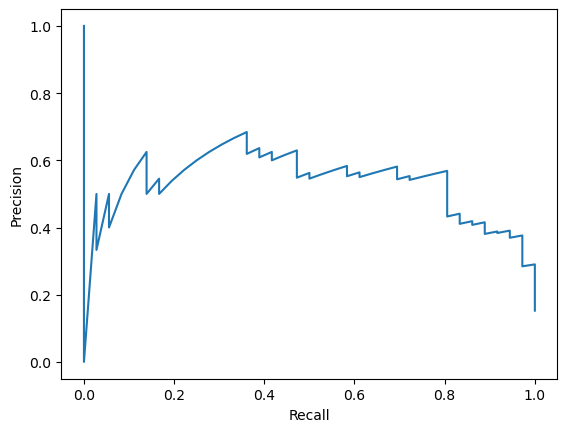

Best PR threshold: 0.31087206292322545
Precision: 0.5576923076923077
Recall: 0.8055555555555556
F1 score: 0.6666666666666667


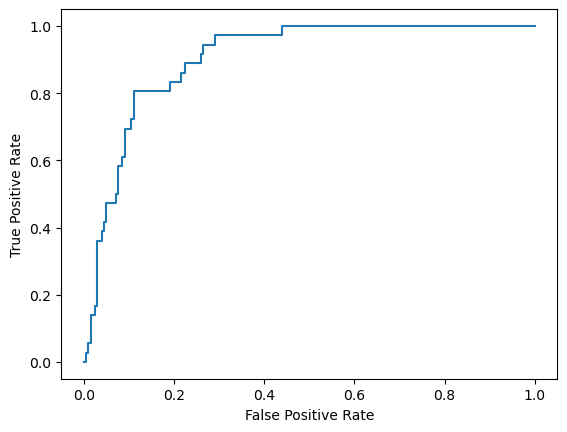

Best ROC threshold: 0.311992572193082
FPR: 0.11
TPR: 0.8055555555555556

Best threshold: 0.3114323175581537


In [393]:
# find best prob threshold based on precision and recall curve
probs = model.rf.predict_proba(x_val)[:,1]
precisions,recalls,pr_thresholds = precision_recall_curve(y_val,probs)
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

f1_scores = []
valid_thresholds = []
for p,r,t in zip(precisions[1:], recalls[1:], pr_thresholds):
    if p+r == 0:
        continue # skip 0 values to avoid div by 0 error
    f1_scores.append(2 * p * r / (p + r))
    valid_thresholds.append(t)
best_idx = np.argmax(f1_scores)
best_pr_threshold = valid_thresholds[best_idx]
print("Best PR threshold:", best_pr_threshold)
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("F1 score:", f1_scores[best_idx])


# find best prob threshold based on Youden's J statistic for fpr and tpr in roc curve 
fpr,tpr,roc_thresholds = roc_curve(y_val,probs)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_roc_threshold = roc_thresholds[best_idx]
print("Best ROC threshold:", best_roc_threshold)
print("FPR:", fpr[best_idx])
print("TPR:", tpr[best_idx])

best_threshold = (best_pr_threshold + best_roc_threshold) / 2
print("\nBest threshold:", best_threshold)



In [394]:
# adjust model threshold to improve performance
model.set_threshold(best_threshold)

Threshold set to: 0.3114323175581537


Training
Accuracy (exact position match): 0.896
ROC AUC: 0.9593668440497577
Average precision: 0.8146970727369688
Recall: 0.8466257668711656 --> Of all the real positives, how many did I catch
Precision: 0.6160714285714286 --> When I say it’s positive, how often am I right
F1 score: 0.7131782945736433


Val
Accuracy (exact position match): 0.877
ROC AUC: 0.9041666666666666
Average precision: 0.5441472323623189
Recall: 0.8055555555555556 --> Of all the real positives, how many did I catch
Precision: 0.5686274509803921 --> When I say it’s positive, how often am I right
F1 score: 0.6666666666666667


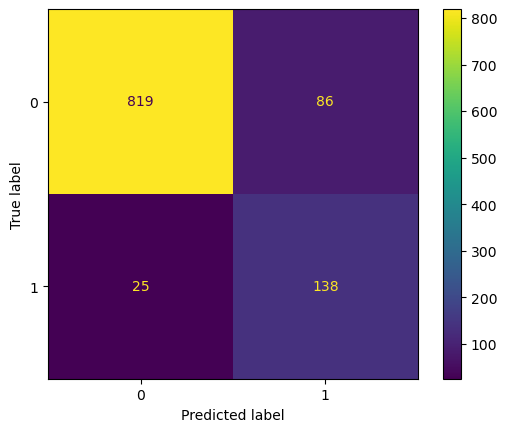

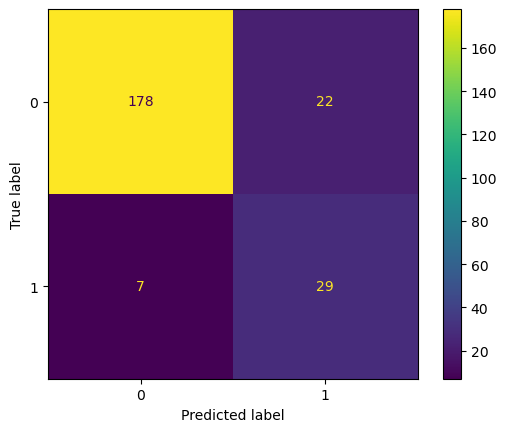

In [395]:
# note here that you're overfitting on the training data with high acc which is good. now just regularize to generalize better
# taking out the location features did improve the training acc slightly but no effect on the val acc. Negligent effect on removing locations for model 1.

# results training data
print("Training")
preds,pred_prob = model.predict(x_trn)
model.get_metrics(preds,y_trn,pred_prob)
print("\n")

# results on val data
print("Val")
preds,pred_prob = model.predict(x_val)
model.get_metrics(preds,y_val,pred_prob)

In [324]:
#preds,pred_prob = model.predict(x_test)
#model.get_metrics(preds,y_test,pred_prob)

### Model Evaluation

In [396]:
# here the higher or lower the auc the better it separates the two classes. Things closer to 0.5 are not good.
feature_auc_df = pd.DataFrame()
for feature in x_trn.columns:
    auc_trn = roc_auc_score(y_trn,x_trn[feature])
    auc_val = roc_auc_score(y_val,x_val[feature])
    feature_auc_df = pd.concat([feature_auc_df,pd.DataFrame([{'feature':feature,'auc_trn':auc_trn, 'auc_val':auc_val}])],axis=0,ignore_index=True)

feature_auc_df.sort_values(by='auc_trn',ascending=False)


,feature,auc_trn,auc_val
3,TopTeam_Red Bull Racing,0.693729,0.521944
4,TopTeam_Ferrari,0.567583,0.636667
5,TopTeam_Mercedes,0.541691,0.521944
6,TopTeam_McLaren,0.510216,0.636667
7,Race_Date_Code,0.499973,0.500000
10,lag_Sector2Time,0.485056,0.474167
1,Sprint_Race_Position,0.480263,0.476875
0,Sprint_Qual_Position,0.480182,0.478958
11,lag_Sector3Time,0.478270,0.470278
9,lag_Sector1Time,0.476745,0.474722


In [397]:
class ModelEval():
    """ A class for evaluation model results """
    def __init__(self,model,x,round_number,driver,country,actual):
        self.model = model
        self.x = x
        self.round_number = round_number
        self.driver = driver
        self.country = country
        self.pred,self.prob= model.predict(x)
        self.actual = actual

        self.pretty_df = self.pretty_predictions()

    # produce pretty def with columns that help identify which driver the results belong to and for which race etc
    def pretty_predictions(self):
        df = self.x.copy()
        df["Round_Number"] = self.round_number
        df["Driver"] = self.driver
        df["Country"] = self.country
        df["Predicted_Probability"] = self.prob
        df["Predicted_Race_Position"] = self.pred
        df["Race_Position"] = self.actual
        cols_to_be_included = ["Round_Number","Driver","Country","Predicted_Probability","Predicted_Race_Position","Race_Position"]
        #df = df[cols_to_be_included].sort_values(by='Predicted_Race_Position')
        df = df[cols_to_be_included]
        df = (
            df
            .groupby("Round_Number", group_keys=False)
            .apply(lambda g: g.sort_values("Predicted_Race_Position"))
            .reset_index(drop=True)
        )
        return df

    def get_driver_with_most_wrong_predictions(self):
        acc_per_driver = self.get_acc_per_driver()
        worst_idx = acc_per_driver['accuracy'].idxmin()
        worst_row = acc_per_driver.loc[worst_idx]
        driver = worst_row['Driver']
        driver_acc = worst_row['accuracy']
        print(f"{driver}: {driver_acc}")
        return self.get_preds_for_driver(driver)

    # return sorted df of drivers that are predicted to finish in the top-k the most
    def get_drivers_with_most_predictions(self):
        top1_df = self.pretty_df[self.pretty_df['Predicted_Race_Position'] == 1]
        pred_top_count_per_driver = (
            top1_df
            .groupby('Driver')["Predicted_Race_Position"]
            .count()
            .reset_index(name='count')
        )
        return pred_top_count_per_driver.sort_values(by='count',ascending=False)

    
    def get_acc_per_driver(self):
        self.pretty_df['correct'] = ( self.pretty_df['Predicted_Race_Position'] == self.pretty_df['Race_Position'])
        acc_per_driver = (
            self.pretty_df
            .groupby('Driver')['correct']
            .mean()
            .reset_index(name='accuracy')
        )
        return acc_per_driver.sort_values(by='accuracy')

    def get_acc_per_race(self):
        round_to_country = (
            self.pretty_df
            .groupby('Round_Number')['Country']
            .first()
            .to_dict()
        )

        self.pretty_df['correct'] = ( self.pretty_df['Predicted_Race_Position'] == self.pretty_df['Race_Position'])

        acc_per_rd = (
            self.pretty_df
            .groupby('Round_Number')['correct']
            .mean()
            .reset_index(name='accuracy')
        )

        acc_per_rd['Country'] = acc_per_rd['Round_Number'].map(round_to_country)
        return acc_per_rd

    # get top-k acc per race.i.e. for top-k ground truth, what percentage of those did model get right
    def get_topk_acc_per_race(self):
        round_to_country = (
        self.pretty_df
        .groupby('Round_Number')['Country']
        .first()
        .to_dict()
        )

        # only keep the actual top‑3 drivers
        mask_actual_top3 = self.pretty_df['Race_Position'] == 1
        df_pos = self.pretty_df[mask_actual_top3].copy()

        # correct if we predicted 1 as well
        df_pos['correct'] = df_pos['Predicted_Race_Position'] == 1

        # now mean over just those rows
        acc_per_rd = (
            df_pos
            .groupby('Round_Number')['correct']
            .mean()
            .reset_index(name='accuracy')
        )
        acc_per_rd['Country'] = acc_per_rd['Round_Number'].map(round_to_country)
        return acc_per_rd


    def get_preds_for_race(self,round_number):
        return self.pretty_df.loc[self.pretty_df["Round_Number"]==round_number,:]
    
    def get_preds_for_driver(self,driver_name='M VERSTAPPEN'):
        return self.pretty_df.loc[self.pretty_df["Driver"]==driver_name,:]

    def get_correct_predictions(self,round_number=None):
        if round_number is not None:
            # positions you guessed correct in round_number
            condition = (self.pretty_df["Predicted_Race_Position"] == self.pretty_df["Race_Position"]) & (self.pretty_df["Round_Number"]==round_number)
            return self.pretty_df.loc[condition,:].sort_values(by='Race_Position')
        else:
            condition = (self.pretty_df["Predicted_Race_Position"] == self.pretty_df["Race_Position"]) 
            return self.pretty_df.loc[condition,:].sort_values(by='Race_Position')    

    # look at which driver positions you predicted correctly within error bound
    def correct_within_error_bound(self):
        total = 0
        error_bound = 1
        within_error_bound = 0
        within_error_bound_df = pd.DataFrame()
        for index,row in self.pretty_df.iterrows():
            pred = row["Predicted_Race_Position"]
            actual = row["Race_Position"]
            driver = row["Driver"]
            if np.abs(pred-actual) <= error_bound:
                within_error_bound += 1 
                within_error_bound_df = pd.concat([within_error_bound_df,pd.DataFrame([row])],axis=0,ignore_index=True)
            total += 1

        print(f"Acc within error bound: {(within_error_bound/total)*100}%")
        return within_error_bound_df

    def plot_pred_vs_truth(self,driver,plt_type='scatter'):
        if driver is None:
            preds = self.pretty_df["Predicted_Race_Position"].values
            truth = self.pretty_df["Race_Position"].values
        else:
            driver_preds = self.get_preds_for_driver(driver)
            preds = driver_preds["Predicted_Race_Position"].values
            truth = driver_preds["Race_Position"].values

        if len(truth) != len(preds): raise Exception('pred len != truth len')
        time = [i for i in range(1,len(truth)+1,1)]
        plt.figure(figsize=(20,10))
        if plt_type == 'scatter':
            plt.scatter(time,preds,color="red",label="Pred")
            plt.scatter(time,truth,color="blue",label="Truth")
        else: 
            plt.plot(time,preds,color="red",label="Pred")
            plt.plot(time,truth,color="blue",label="Truth")
        plt.legend()
        plt.show()

In [398]:
#model2_eval_test = ModelEval(model,x_test,test_round_number,test_driver,test_country,y_test)
model2_eval_val = ModelEval(model,x_val,val_round_number,val_driver,val_country,y_val)

In [3490]:
# test

#model2_eval_test.get_preds_for_race(2)
#model2_eval_test.get_preds_for_driver('C LECLERC')
#model2_eval_test.plot_pred_vs_truth(None,'line')
#model2_eval_test.plot_pred_vs_truth('C LECLERC','line')
#model2_eval_test.get_driver_with_most_wrong_predictions()
#model2_eval_test.get_acc_per_race()
#model2_eval_test.get_acc_per_driver()
#model2_eval_test.get_topk_acc_per_race()


In [404]:
# val

#model2_eval_val.pretty_df
#model2_eval_val.get_preds_for_race(21)
#model2_eval_val.get_preds_for_driver('C LECLERC')
#model2_eval_val.plot_pred_vs_truth(None,'line')
#model2_eval_val.plot_pred_vs_truth('C LECLERC','line')
#model2_eval_val.get_correct_predictions(15)
#model2_eval_val.get_driver_with_most_wrong_predictions()
#model2_eval_val.get_acc_per_race()
#model2_eval_val.get_acc_per_driver()
#model2_eval_val.get_topk_acc_per_race()
#model2_eval_val.get_drivers_with_most_predictions()


In [400]:
model.threshold

0.3114323175581537